# Building a classifier for New Zealand coins
[Dataset](https://www.kaggle.com/datasets/wanderdust/coin-images/code)

This dataset was modified to only include New Zealand coins.

In [3]:
import os
import json
import numpy as np
from enum import Enum
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
import torch.optim as optim
import torch.nn as nn
from torcheval.metrics import MulticlassAccuracy

/home/dude/anaconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
BASE_MODEL = "resnet18"
EPOCHS = 2000
BATCH_SIZE = 32
IM_SIZE = 64
LEARNING_RATE = 0.001
MOMENTUM = 0.9
SAVE_EVERY_N_EPOCHS = 10
VALIDATE_EVERY_N_EPOCHS = 5
SAVE_DIR = os.path.join("training", "v1")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [5]:
class DatatsetType(Enum):
    TRAIN = 0
    VALIDATION = 1
    TEST = 2

    def dir(self):
        if self == DatatsetType.TRAIN:
            return 'train'
        elif self == DatatsetType.VALIDATION:
            return 'validation'
        elif self == DatatsetType.TEST:
            return 'test'

class NZCoinDataset(Dataset):
    JSON_INFO_FP = "cat_to_name.json"
    root_dir: str
    dataset_type: DatatsetType
    transform: any
    idx_to_lbl: dict[int, str]
    lbl_to_idx: dict[str, int]

    def __init__(self, root_dir: str, dataset_type: DatatsetType, transform=None) -> None:
        self.root_dir = root_dir
        self.dataset_type = dataset_type
        self.transform = transform

        available_labels = sorted(os.listdir(os.path.join(root_dir, "data", dataset_type.dir())))
        available_labels_from_0 = {lbl: i for i, lbl in enumerate(available_labels)}
        with open(os.path.join(root_dir, self.JSON_INFO_FP), 'r') as f:
            description = json.load(f)
            self.idx_to_lbl = {available_labels_from_0[k]: v.split(',')[0] for k, v in description.items() if k in available_labels_from_0}
            self.lbl_to_idx = {v: k for k, v in self.idx_to_lbl.items()}

        self.ims = []
        self.ims_idxs = []
        for lbl in available_labels:
            idx = available_labels_from_0[lbl]
            for im in os.listdir(os.path.join(root_dir, "data", dataset_type.dir(), lbl)):
                self.ims.append(os.path.join(lbl, im))
                self.ims_idxs.append(idx)

        self.ims = np.array(self.ims)
        self.ims_idxs = np.array(self.ims_idxs)

    def __len__(self):
        return len(self.ims)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join( self.root_dir, "data", self.dataset_type.dir(), self.ims[idx])
        image = read_image(img_path)
        label = self.ims_idxs[idx]

        if self.transform:
            image = self.transform(image)

        return image, label
    


transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize(IM_SIZE),
    transforms.CenterCrop(IM_SIZE),
])
        
train_data = NZCoinDataset('coin_dataset', DatatsetType.TEST, transform=transform)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

def compute_mean_std(ds: NZCoinDataset):
    mean = np.zeros(3)
    std = np.zeros(3)
    for i, (img, _) in enumerate(ds):
        mean += torch.mean(img, dim=(1, 2)).tolist()
        std += torch.std(img, dim=(1, 2)).tolist()
    mean /= len(ds)
    std /= len(ds)
    return mean, std

mean, std = compute_mean_std(train_data)
transform = transforms.Compose([
    transforms.AutoAugment(),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize(IM_SIZE),
    transforms.CenterCrop(IM_SIZE),
    transforms.Normalize(mean, std),
    transforms.RandomRotation(180),
])

no_rand_transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize(IM_SIZE),
    transforms.CenterCrop(IM_SIZE),
    transforms.Normalize(mean, std),
])


train_data = NZCoinDataset('coin_dataset', DatatsetType.TRAIN, transform=transform)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

valid_data = NZCoinDataset('coin_dataset', DatatsetType.VALIDATION, transform=transform)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)

test_data = NZCoinDataset('coin_dataset', DatatsetType.TEST, transform=no_rand_transform)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

print(f"{len(train_data)} samples")

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, lbl_idx = train_data[sample_idx]
    img = img.permute(1, 2, 0)
    figure.add_subplot(rows, cols, i)
    plt.title(train_data.idx_to_lbl[lbl_idx])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.015172756165887757..1.0000002376894819].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.185313635079012e-08..1.0000002376894819].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.185313635079012e-08..0.9411765933721081].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.185313635079012e-08..0.8268844617596052].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.185313635079012e-08..0.5871306383609771].


IndexError: index 8 is out of bounds for axis 0 with size 8

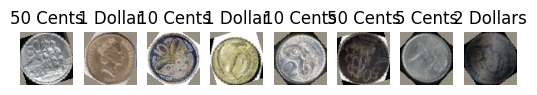

In [8]:
def display_ims(loader):
    def unnormalize(img):
        return img * std + mean
    for i, (img, lbl) in enumerate(loader):
        fig, axs = plt.subplots(1, min(BATCH_SIZE, 8))
        for j in range(BATCH_SIZE):
            # images are 3 channel
            ims = img[j].permute(1, 2, 0)
            ims = unnormalize(ims)
            axs[j].imshow(ims)
            axs[j].set_title(f"{train_data.idx_to_lbl[lbl[j].item()]}")
            axs[j].axis('off')
        plt.show()
        break

display_ims(train_loader)

In [9]:
model = torch.hub.load('pytorch/vision:v0.10.0', BASE_MODEL, pretrained=True)
model.eval()
model.to(DEVICE)

Using cache found in /home/dude/.cache/torch/hub/pytorch_vision_v0.10.0
/home/dude/anaconda3/envs/ml/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dude/anaconda3/envs/ml/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
train_metric  = MulticlassAccuracy(device=DEVICE)
valid_metric = MulticlassAccuracy(device=DEVICE)

In [11]:
# try to load model
def sort_model_paths(paths):
    return sorted(paths, key=lambda x: int(x.split('_')[1].split('.')[0]))
latest_model = sort_model_paths(os.listdir(SAVE_DIR))
last_epoch = 0
if len(latest_model) > 0:
    latest_model = latest_model[-1]
    last_epoch = int(latest_model.split('_')[1].split('.')[0])
    model.load_state_dict(torch.load(os.path.join(SAVE_DIR, latest_model)))
    print(f"Loaded model from {latest_model}")

Loaded model from model_1990.pt


In [210]:
for epoch in range(last_epoch, EPOCHS):
    train_metric.reset()
    running_loss = 0.0
    for i, (img, lbl) in enumerate(train_loader):
        img, lbl = img.to(DEVICE), lbl.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(img)
        loss = criterion(outputs, lbl)
        loss.backward()
        optimizer.step()
        train_metric.update(outputs, lbl)
        running_loss += loss.item()
    
    if epoch % VALIDATE_EVERY_N_EPOCHS == 0:
        for i, (img, lbl) in enumerate(valid_loader):
            img, lbl = img.to(DEVICE), lbl.to(DEVICE)
            outputs = model(img)
            valid_metric.update(outputs, lbl)
        print(f"Epoch {epoch} - Loss: {running_loss / len(train_loader):.4f}", end=' ')
        print(f"Train Acc: {train_metric.compute():.4f}", end=' ')
        print(f"Valid Acc: {valid_metric.compute():.4f}")

    if epoch % SAVE_EVERY_N_EPOCHS == 0:
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, f"model_{epoch}.pt"))

print("Finished training")

Epoch 490 - Loss: 0.3247 Train Acc: 0.8988 Valid Acc: 0.7708
Epoch 495 - Loss: 0.1949 Train Acc: 0.9464 Valid Acc: 0.7222
Epoch 500 - Loss: 0.2879 Train Acc: 0.8988 Valid Acc: 0.7188
Epoch 505 - Loss: 0.1300 Train Acc: 0.9464 Valid Acc: 0.7083
Epoch 510 - Loss: 0.1206 Train Acc: 0.9524 Valid Acc: 0.7153
Epoch 515 - Loss: 0.2358 Train Acc: 0.9286 Valid Acc: 0.7202
Epoch 520 - Loss: 0.2461 Train Acc: 0.9345 Valid Acc: 0.7031
Epoch 525 - Loss: 0.3131 Train Acc: 0.8750 Valid Acc: 0.7083
Epoch 530 - Loss: 0.2044 Train Acc: 0.9226 Valid Acc: 0.7083
Epoch 535 - Loss: 0.1878 Train Acc: 0.9167 Valid Acc: 0.7197
Epoch 540 - Loss: 0.1306 Train Acc: 0.9583 Valid Acc: 0.7153
Epoch 545 - Loss: 0.2151 Train Acc: 0.9702 Valid Acc: 0.7212
Epoch 550 - Loss: 0.1700 Train Acc: 0.9405 Valid Acc: 0.7262
Epoch 555 - Loss: 0.2081 Train Acc: 0.8929 Valid Acc: 0.7361
Epoch 560 - Loss: 0.1468 Train Acc: 0.9286 Valid Acc: 0.7344
Epoch 565 - Loss: 0.1566 Train Acc: 0.9464 Valid Acc: 0.7279
Epoch 570 - Loss: 0.1778

In [12]:
test_metric = MulticlassAccuracy(device=DEVICE)
test_metric.reset()
for i, (img, lbl) in enumerate(test_loader):
    img, lbl = img.to(DEVICE), lbl.to(DEVICE)
    outputs = model(img)
    test_metric.update(outputs, lbl)
print(f"Test Acc: {test_metric.compute():.2f}")

Test Acc: 0.84


100%|██████████| 200/200 [02:48<00:00,  1.19it/s]


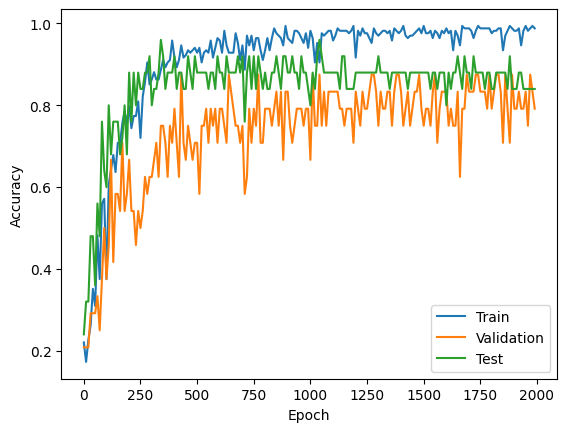

In [14]:
# load each model and evaluate train, validation and test
epochs = []
train_acc = []
valid_acc = []
test_acc = []
for model_fp in tqdm(sort_model_paths(os.listdir(SAVE_DIR))):
    model.load_state_dict(torch.load(os.path.join(SAVE_DIR, model_fp)))
    train_metric.reset()
    valid_metric.reset()
    test_metric.reset()
    for i, (img, lbl) in enumerate(train_loader):
        img, lbl = img.to(DEVICE), lbl.to(DEVICE)
        outputs = model(img)
        train_metric.update(outputs, lbl)
    for i, (img, lbl) in enumerate(valid_loader):
        img, lbl = img.to(DEVICE), lbl.to(DEVICE)
        outputs = model(img)
        valid_metric.update(outputs, lbl)
    for i, (img, lbl) in enumerate(test_loader):
        img, lbl = img.to(DEVICE), lbl.to(DEVICE)
        outputs = model(img)
        test_metric.update(outputs, lbl)
    epochs.append(int(model_fp.split('_')[-1].split('.')[0]))
    train_acc.append(train_metric.compute().cpu().numpy())
    valid_acc.append(valid_metric.compute().cpu().numpy())
    test_acc.append(test_metric.compute().cpu().numpy())

plt.plot(epochs, train_acc, label='Train')
plt.plot(epochs, valid_acc, label='Validation')
plt.plot(epochs, test_acc, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

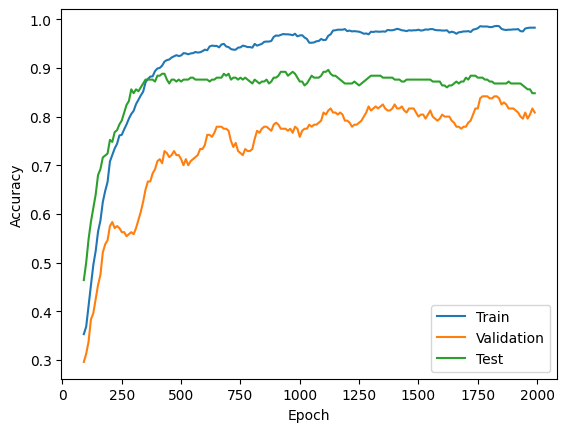

In [15]:
smoothed_train_acc = np.convolve(train_acc, np.ones(10)/10, mode='valid')
smoothed_valid_acc = np.convolve(valid_acc, np.ones(10)/10, mode='valid')
smoothed_test_acc = np.convolve(test_acc, np.ones(10)/10, mode='valid')

plt.plot(epochs[9:], smoothed_train_acc, label='Train')
plt.plot(epochs[9:], smoothed_valid_acc, label='Validation')
plt.plot(epochs[9:], smoothed_test_acc, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [242]:
details = {
    "model": BASE_MODEL,
    "weight_path": sort_model_paths(os.listdir(SAVE_DIR))[-1],
    "mean": list(mean),
    "std": list(std),
    "im_size": IM_SIZE,
    "classes": train_data.idx_to_lbl
}
with open(os.path.join(SAVE_DIR, "details.json"), 'w') as f:
    json.dump(details, f, indent=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.11752500779977876..1.0000001424273237].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.185313635079012e-08..0.9861021249378177].


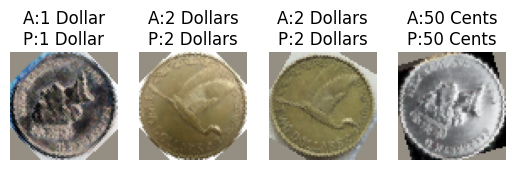

In [236]:
def display_with_predictions(loader):
    def unnormalize(img):
        return img * std + mean
    for i, (img, lbl) in enumerate(loader):
        n = min(BATCH_SIZE, 4)
        fig, axs = plt.subplots(1, n)
        for j in range(n):
            device_ims = img[j].unsqueeze(0).to(DEVICE)
            outputs = model(device_ims)
            ims = img[j].permute(1, 2, 0)
            ims = unnormalize(ims)
            axs[j].imshow(ims)
            pred = torch.argmax(outputs).item()
            axs[j].set_title(f"A:{train_data.idx_to_lbl[lbl[j].item()]}\nP:{train_data.idx_to_lbl[pred]}")
            axs[j].axis('off')
        plt.show()
        break

display_with_predictions(test_loader)